In [2]:
#Importing libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
import apimoex
import sqlite3
import json
import os
import time

from utils.data_loader import index_history
from utils.data_loader import ticker_prices, get_ticker_history
from pypfopt import expected_returns, risk_models, EfficientFrontier, objective_functions

import warnings
warnings.filterwarnings('ignore')

In [10]:
# Функция для получения списка акций и депозитарных расписок
def get_moex_stocks():
    # URL для получения списка акций
    url = "https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities.json"
    
    params = {
        'iss.meta': 'off',  # Отключаем метаданные
        'iss.only': 'securities',  # Получаем только данные о ценных бумагах
        'securities.columns': 'SECID,SHORTNAME,SECNAME,ISIN,PREVPRICE,LOTSIZE,FACEVALUE,FACEUNIT,PREVDATE'  # Нужные колонки
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Преобразуем данные в DataFrame
    df_stocks = pd.DataFrame(data['securities']['data'], 
                           columns=data['securities']['columns'])
    
    return df_stocks

def get_moex_dr():
    # URL для получения депозитарных расписок
    url = "https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBD/securities.json"
    
    params = {
        'iss.meta': 'off',
        'iss.only': 'securities',
        'securities.columns': 'SECID,SHORTNAME,SECNAME,ISIN,PREVPRICE,LOTSIZE,FACEVALUE,FACEUNIT,PREVDATE'
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Преобразуем данные в DataFrame
    df_dr = pd.DataFrame(data['securities']['data'], 
                         columns=data['securities']['columns'])
    
    return df_dr

# Функция для получения списка ETF/фондов
def get_moex_etfs():
    # URL для получения списка ETF
    url = "https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQTF/securities.json"
    
    params = {
        'iss.meta': 'off',
        'iss.only': 'securities',
        'securities.columns': 'SECID,SHORTNAME,SECNAME,ISIN,PREVPRICE,LOTSIZE,FACEVALUE,FACEUNIT,PREVDATE'
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Преобразуем данные в DataFrame
    df_etfs = pd.DataFrame(data['securities']['data'], 
                          columns=data['securities']['columns'])
    
    return df_etfs

In [6]:
df = get_moex_stocks()
df

,SECID,SHORTNAME,SECNAME,ISIN,PREVPRICE,LOTSIZE,FACEVALUE,FACEUNIT,PREVDATE
0,ABIO,iАРТГЕН ао,"ПАО ""Артген""",RU000A0JNAB6,83.740,10,0.10,SUR,2025-04-04
1,ABRD,АбрауДюрсо,Абрау-Дюрсо ПАО ао,RU000A0JS5T7,181.000,10,1.00,SUR,2025-04-04
2,AFKS,Система ао,"АФК ""Система"" ПАО ао",RU000A0DQZE3,15.671,100,0.09,SUR,2025-04-04
3,AFLT,Аэрофлот,Аэрофлот-росс.авиалин(ПАО)ао,RU0009062285,66.460,10,1.00,SUR,2025-04-04
4,AGRO,AGRO-гдр,ГДР ROS AGRO PLC ORD SHS,US7496552057,1083.800,1,0.00,USD,2025-04-04
...,...,...,...,...,...,...,...,...,...
254,YRSB,ТНСэнЯр,ТНС энерго Ярославль ПАО ао,RU000A0D8760,736.000,10,1.00,SUR,2025-04-04
255,YRSBP,ТНСэнЯр-п,ТНС энерго Ярославль ПАО ап,RU000A0D88B3,182.500,10,1.00,SUR,2025-04-04
256,ZAYM,Займер ао,Займер ао,RU000A107RM8,141.450,10,0.10,SUR,2025-04-04
257,ZILL,ЗИЛ ао,Завод им. И.А.Лихачева ПАО ао,RU0009086193,3735.000,1,1000.00,SUR,2025-04-04


In [57]:
df = get_moex_etfs()
df

,SECID,SHORTNAME,SECNAME,ISIN,PREVPRICE,LOTSIZE,FACEVALUE,FACEUNIT,PREVDATE
0,AKAI,AKAI ETF,БПИФ Антиинфляционный,RU000A109PQ9,102.94,1,0,SUR,2025-04-04
1,AKBC,AKBC ETF,БПИФ Альфа Индекс голуб фишек,RU000A10B6F8,NaN,1,0,SUR,0000-00-00
2,AKFB,AKFB ETF,БПИФ Альфа Обл с перем купоном,RU000A109T66,107.66,1,0,SUR,2025-04-04
3,AKGD,AKGD ETF,БПИФ Альфа Капитал Золото,RU000A1045N8,192.52,1,0,SUR,2025-04-04
4,AKHT,AKHT ETF,БПИФ Альфа Капитал ИТ Лидеры,RU000A109VF0,95.25,1,0,SUR,2025-04-04
...,...,...,...,...,...,...,...,...,...
79,TPAY,TPAY ETF,Т-Капитал Пассивный Доход,RU000A108WX3,94.86,1,0,SUR,2025-04-04
80,TRND,TRND ETF,БПИФ Т-Капитал Трендовые акции,RU000A10B0G9,8.76,1,0,SUR,2025-04-04
81,TRUR,TRUR ETF,БПИФ Т-Кап ВЕЧНЫЙ ПОРТФ РУБ,RU000A1011U5,8.54,1,0,SUR,2025-04-04
82,TUSD,TUSD ETF,БПИФ ТКАПИТАЛ ВЕЧНЫЙ ПОРТФ Д,RU000A1011S9,5.75,1,0,SUR,2025-04-04


In [2]:
def get_moex_indices():
    # URL для получения списка индексов
    url = "https://iss.moex.com/iss/statistics/engines/stock/markets/index/analytics.json"
    
    params = {
        'iss.meta': 'off',  # Отключаем метаданные
        'limit': 100,       # Лимит количества записей
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Сначала выведем структуру JSON для отладки
    print("Ключи в ответе:", data.keys())
    
    # Попробуем использовать правильный ключ
    if 'analytics' in data:
        df_indices = pd.DataFrame(data['analytics']['data'], 
                                columns=data['analytics']['columns'])
    else:
        # Если ключа нет, попробуем другой подход
        return get_moex_indices_detailed()
    
    return df_indices

def get_moex_indices_detailed():
    # URL для получения более подробной информации об индексах
    url = "https://iss.moex.com/iss/engines/stock/markets/index/securities.json"
    
    params = {
        'iss.meta': 'off',
        'iss.only': 'securities',
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Отладочная информация
    print("Ключи в ответе detailed:", data.keys())
    
    # Преобразуем данные в DataFrame, если ключ существует
    if 'securities' in data:
        columns = data['securities']['columns']
        df_indices = pd.DataFrame(data['securities']['data'], columns=columns)
        return df_indices
    else:
        # Выведем полностью структуру для анализа
        print("Полная структура ответа:", json.dumps(data, indent=2)[:500])
        return pd.DataFrame()  # Возвращаем пустой DataFrame если ничего не нашли

# Вспомогательная функция для обследования API
def explore_api_structure(url, params=None):
    """Исследует структуру ответа API"""
    if params is None:
        params = {'iss.meta': 'off'}
    
    response = requests.get(url, params=params)
    data = response.json()
    
    print(f"URL: {url}")
    print(f"Статус: {response.status_code}")
    print(f"Ключи верхнего уровня: {list(data.keys())}")
    
    for key in data.keys():
        if isinstance(data[key], dict) and 'data' in data[key]:
            print(f"Ключ '{key}' содержит данные. Columns: {len(data[key]['columns'])}, Rows: {len(data[key]['data'])}")
    
    return data

def get_index_components(index_id="IMOEX"):
    url = f"https://iss.moex.com/iss/statistics/engines/stock/markets/index/analytics/{index_id}.json"
    
    params = {
        'iss.meta': 'off',
        'limit': 100
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Преобразуем данные в DataFrame
    df_components = pd.DataFrame(data['analytics']['data'], 
                               columns=data['analytics']['columns'])
    
    return df_components

In [19]:
df = get_moex_indices()
df

Ключи в ответе: dict_keys(['indices'])
Ключи в ответе detailed: dict_keys(['securities'])


,SECID,BOARDID,NAME,DECIMALS,SHORTNAME,ANNUALHIGH,ANNUALLOW,CURRENCYID,CALCMODE
0,2xEQT,INAV,Расчетная цена одного пая интервального ПИФа «...,2,iNAV 2xEQT,2822.0800,770.4600,RUB,IE
1,2xOFZ,INAV,Расчетная цена одного пая интервального ПИФа «...,2,iNAV 2xOFZ,130229.9400,82784.9300,RUB,IF
2,AKAIA,INAV,"Расчётная цена одного пая Биржевого ПИФа РФИ ""...",4,iNAV Альфа Антиинфляционный,114.1794,90.2701,RUB,MX
3,AKBCA,INAV,Расчетная цена одного пая Биржевого ПИФа РФИ «...,4,iNAV Альфа-Капитал Голубые фишки,94.1219,88.1091,RUB,IE
4,AKCBI,RTSI,Индикатор «Альфа-Капитал. Облигации»,4,iАльфа-Капитал Облигации,1354.8100,1243.9900,RUB,Совокупный д
...,...,...,...,...,...,...,...,...,...
712,VTBYE,INAV,Биржевой паевой инвестиционный фонд РФИ «РСХБ ...,4,iNAV VTBY ETF,1.1468,0.7993,EUR,IF
713,WH4CPTNOV,AGRO,Индекс цен пшеницы по итогам товарных аукционо...,2,Индекс пшеницы НТБ,18896.0000,13435.0000,RUB,GR
714,WHFOB,RTSI,Индекс пшеницы FOB регион Черного моря,1,WHFOB,248.1000,213.1000,USD,CP
715,YUANA,INAV,Расчётная цена одного пая Биржевого ПИФа РФИ «...,2,iNAV Облигации в юанях,9.1700,8.3300,CNY,IF


In [58]:
df.to_csv('moex_etf.csv', index=False, encoding='utf-8-sig')

In [33]:
boardid_counts = df['BOARDID'].value_counts()
print(boardid_counts)

BOARDID
RTSI    340
INAV    225
SNDX     69
INPF     62
MMIX     15
AGRO      5
SDII      1
Name: count, dtype: int64


In [22]:
df['BOARDID'] == ''

array(['INAV', 'RTSI', 'INPF', 'SNDX', 'SDII', 'MMIX', 'AGRO'],
      dtype=object)

In [20]:
df[df['BOARDID'] == 'INPF']

,SECID,BOARDID,NAME,DECIMALS,SHORTNAME,ANNUALHIGH,ANNUALLOW,CURRENCYID,CALCMODE
87,FIXAFKS,INPF,Фиксинг МосБиржи обыкновенных акций ПАО АФК Си...,3,Фиксинг МосБиржи AFKS,29.404,11.6780,RUB,FIX
88,FIXAFLT,INPF,Фиксинг МосБиржи обыкновенных акций ПАО Аэрофлот,2,Фиксинг МосБиржи AFLT,78.060,45.4000,RUB,FIX
89,FIXAGRO,INPF,Фиксинг МосБиржи ДР РОС АГРО ПЛС,1,Фиксинг МосБиржи AGRO,1605.900,1107.4000,RUB,FIX
90,FIXALRS,INPF,Фиксинг МосБиржи обыкновенных акций АК АЛРОСА ...,2,Фиксинг МосБиржи ALRS,81.570,45.5300,RUB,FIX
91,FIXASTR,INPF,Фиксинг МосБиржи обыкновенных акций ПАО Группа...,2,Фиксинг МосБиржи ASTR,586.960,399.8000,RUB,FIX
...,...,...,...,...,...,...,...,...,...
144,FIXVKCO,INPF,Фиксинг МосБиржи обыкновенных акций МКПАО ВК,1,Фиксинг МосБиржи VKCO,628.000,236.3000,RUB,FIX
145,FIXVTBR,INPF,Фиксинг МосБиржи обыкновенных акций Банк ВТБ (...,6,Фиксинг МосБиржи VTBR,101.160,0.0191,RUB,FIX
146,FIXYDEX,INPF,Фиксинг МосБиржи обыкновенных акций МКПАО ЯНДЕКС,1,Фиксинг МосБиржи YDEX,4699.500,3209.9000,RUB,FIX
147,FIXYNDX,INPF,Фиксинг МосБиржи обыкновенных акций Яндекс Н.В.,1,Фиксинг МосБиржи YNDX,4475.100,2204.9000,RUB,FIX


In [50]:
df[df['BOARDID'] == 'SNDX'].to_csv('moex_indexes_sndx.csv', index=False, encoding='utf-8-sig')


In [56]:
df_comp = get_index_components('MOEXBC')
df_comp.to_csv('MOEXBMI.csv', index=False, encoding='utf-8-sig')

In [23]:
df_comp = get_index_components('MOEXBC')
ticker_list = df_comp['secids'].to_list()

In [27]:
conn = sqlite3.connect("moex_data.db")
tickers = pd.read_sql("SELECT * FROM candles ", conn)
tickers

,ticker,tradedate,open,high,low,close,volume,value,boardid
0,CBOM,2015-07-01,3.6270,3.740,3.6240,3.6800,22000500.0,7.991831e+07,TQBR
1,CBOM,2015-07-02,3.8000,3.800,3.6240,3.6455,27706400.0,1.008043e+08,TQBR
2,CBOM,2015-07-03,3.7250,3.725,3.6315,3.6370,38211300.0,1.391775e+08,TQBR
3,CBOM,2015-07-06,3.6405,3.670,3.6400,3.6700,8407400.0,3.069886e+07,TQBR
4,CBOM,2015-07-07,3.8000,3.800,3.6310,3.6310,30483800.0,1.108124e+08,TQBR
...,...,...,...,...,...,...,...,...,...
571733,YRSB,2025-04-07,730.0000,746.000,718.0000,734.0000,630.0,4.583600e+05,TQBR
571734,YRSBP,2025-04-07,179.0000,182.500,148.5000,181.0000,3200.0,5.505650e+05,TQBR
571735,ZAYM,2025-04-07,144.6000,144.600,135.0000,139.7500,436670.0,6.122944e+07,TQBR
571736,ZILL,2025-04-07,3670.0000,3750.000,3510.0000,3680.0000,583.0,2.144020e+06,TQBR


In [25]:
conn = sqlite3.connect("moex_data.db")
tickers = pd.read_sql("SELECT tradedate, ticker, close FROM candles WHERE ticker IN ({})".format(','.join(['?'] * len(ticker_list))), conn, params=ticker_list)
tickers_pivot = tickers.pivot(index='tradedate', columns='ticker', values='close')
tickers_pivot

ticker,CHMF,GAZP,GMKN,HEAD,LKOH,MOEX,NLMK,NVTK,PLZL,ROSN,SBER,SNGS,T,TATN,YDEX
tradedate,,,,,,,,,,,,,,,
2002-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.90,NaN
2002-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.40,NaN
2002-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.35,NaN
2002-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.70,NaN
2002-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.61,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-04,1081.4,126.70,110.90,3088.0,6445.5,194.90,129.28,1145.4,1741.2,441.3,285.35,23.090,3040.0,618.20,4088.0
2025-04-05,1084.2,126.28,110.70,3064.0,6486.0,193.77,128.60,1157.0,1725.0,440.0,284.98,23.330,3047.0,608.10,4100.0
2025-04-06,1105.0,128.54,111.94,3099.0,6587.5,196.35,130.56,1175.4,1743.0,447.5,290.35,23.475,3113.4,623.50,4189.0


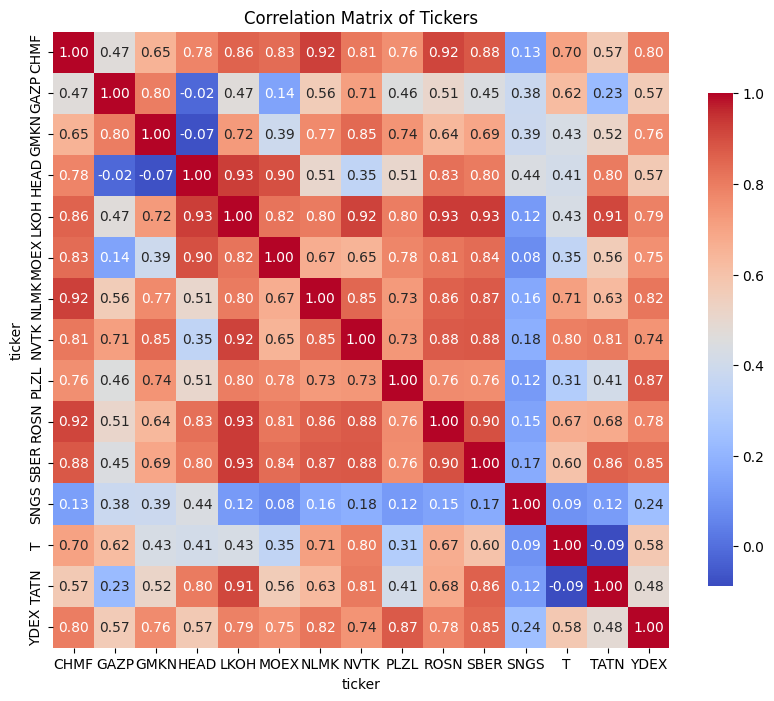

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = tickers_pivot.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Tickers')
plt.show()

In [4]:
from api.combined_opt_hist import run_optimizer
from core.history import get_portfolio_history

tickers = ['SBER', 'LKOH', 'ROSN']

result = optimizer_for_tickers(tickers)
weights = result.get("weights", {})
df_history, message = get_portfolio_history(weights, start_date='2022-01-01', end_date='2025-04-07')
result["history"] = df_history.to_dict(orient="records")
result["history_message"] = message
result

Expected annual return: 12.0%
Annual volatility: 35.0%
Sharpe Ratio: 0.34


{'weights': {'LKOH': 1.0, 'ROSN': 0.0, 'SBER': 0.0},
 'performance': {'return': np.float64(0.11963316448555236),
  'volatility': np.float64(0.3498837991702253),
  'sharpe_ratio': np.float64(0.34192256048799935)},
 'history': [{'tradedate': Timestamp('2022-01-03 00:00:00'),
   'portfolio_value': 6683.0},
  {'tradedate': Timestamp('2022-01-04 00:00:00'), 'portfolio_value': 6728.0},
  {'tradedate': Timestamp('2022-01-05 00:00:00'), 'portfolio_value': 6522.0},
  {'tradedate': Timestamp('2022-01-06 00:00:00'), 'portfolio_value': 6699.0},
  {'tradedate': Timestamp('2022-01-10 00:00:00'), 'portfolio_value': 6775.0},
  {'tradedate': Timestamp('2022-01-11 00:00:00'), 'portfolio_value': 6816.0},
  {'tradedate': Timestamp('2022-01-12 00:00:00'), 'portfolio_value': 6960.0},
  {'tradedate': Timestamp('2022-01-13 00:00:00'), 'portfolio_value': 6665.0},
  {'tradedate': Timestamp('2022-01-14 00:00:00'), 'portfolio_value': 6659.0},
  {'tradedate': Timestamp('2022-01-17 00:00:00'), 'portfolio_value': 65

In [16]:
df = pd.read_csv(
    r"C:\Users\sofya\Desktop\Export_ru_securities-list_20250405.csv",
    encoding='utf-8',  # кодировка Windows, часто используется в России
    sep=';',            # разделитель — точка с запятой
    on_bad_lines='skip' # игнорируем строки с ошибками
)
df_stocks = df[df['SUPERTYPE'] == 'Депозитарные расписки']
tickers = df_stocks['TRADE_CODE']
tickers_list = tickers.tolist()
tickers_list

['ETLN', 'FIXP', 'QIWI', 'OKEY', 'OZON', 'AGRO']

In [15]:
import os
import pandas as pd
import requests
import sqlite3
from time import sleep

DB_NAME = "moex_data.db"
DATA_DIR = "csv_data"

os.makedirs(DATA_DIR, exist_ok=True)

# --- Создание таблиц SQLite ---
def create_tables():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS securities (
            ticker TEXT PRIMARY KEY,
            name TEXT,
            boardid TEXT,
            type TEXT,
            currency TEXT,
            is_active INTEGER DEFAULT 1
        )
    """)

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS candles (
            ticker TEXT,
            tradedate TEXT,
            open REAL,
            high REAL,
            low REAL,
            close REAL,
            volume REAL,
            value REAL,
            boardid TEXT,
            PRIMARY KEY (ticker, tradedate)
        )
    """)

    conn.commit()
    conn.close()

# --- Получение исторических данных с MOEX ---
def fetch_candles(ticker, board='TQBR'):
    url = f"https://iss.moex.com/iss/engines/stock/markets/shares/boards/{board}/securities/{ticker}/candles.json"
    params = {
        "from": "2000-01-01",
        "interval": 24,
        "iss.meta": "off",
        "iss.json": "extended",
        "candles.columns": "begin,open,high,low,close,value,volume"
    }

    all_data = []
    start = 0

    while True:
        try:
            r = requests.get(url, params={**params, "start": start}, timeout=15)
            r.raise_for_status()
            data = r.json()

            if len(data) < 2 or "candles" not in data[1]:
                break

            candles = data[1]["candles"]
            if not candles:
                break

            all_data.extend(candles)

            start += 500
            sleep(0.2)  # чтобы не получить бан

        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
            break

    df = pd.DataFrame(all_data, columns=["begin", "open", "high", "low", "close", "value", "volume"])
    df.rename(columns={"begin": "tradedate"}, inplace=True)
    df["tradedate"] = pd.to_datetime(df["tradedate"]).dt.date  # удаляем время
    df.insert(0, "ticker", ticker)
    df["boardid"] = board

    return df

# --- Сохранение в CSV и SQLite ---
def save_data(df):
    ticker = df["ticker"].iloc[0]

    before = len(df)
    df = df.drop_duplicates(subset=["ticker", "tradedate"])
    after = len(df)
    removed = before - after
    if removed > 0:
        print(f"Removed {removed} duplicate rows for {ticker}")

    # Save to CSV
    df.to_csv(os.path.join(DATA_DIR, f"{ticker}.csv"), index=False)

    # Save to SQLite
    conn = sqlite3.connect(DB_NAME)
    try:
        df.to_sql("candles", conn, if_exists="append", index=False)
    except sqlite3.IntegrityError as e:
        print(f"❌ Ошибка вставки {ticker}: {e}")
    finally:
        conn.close()

# --- Пример работы ---
if __name__ == "__main__":
    create_tables()
    tickers = tickers_list  # заменишь на свой список

    for ticker in tickers:
        df = fetch_candles(ticker)
        if not df.empty:
            save_data(df)
            print(f"Saved: {ticker} ({len(df)} rows)")
        else:
            print(f"No data for {ticker}")


Saved: CBOM (2461 rows)
Saved: ALRS (3144 rows)
Saved: VTBR (3040 rows)
Saved: MDMG (1085 rows)
Saved: GEMC (899 rows)
Saved: VKCO (803 rows)
Saved: LENT (820 rows)
Saved: RUAL (2520 rows)
Saved: T (1344 rows)
Saved: HEAD (141 rows)
Saved: CNRU (2 rows)
Saved: ENPG (1288 rows)
Saved: YDEX (187 rows)
Saved: BSPB (2723 rows)
Saved: AQUA (2360 rows)
Saved: AFKS (2725 rows)
Saved: AFLT (4297 rows)
Saved: VSEH (193 rows)
Saved: GAZP (2725 rows)
Saved: GMKN (3042 rows)
Saved: RAGR (35 rows)
Saved: LSRG (3550 rows)
Saved: POSI (824 rows)
Saved: RENI (860 rows)
Saved: EUTR (353 rows)
Saved: IRAO (3386 rows)
Saved: X5 (69 rows)
Saved: LEAS (268 rows)
Saved: MVID (2719 rows)
Saved: MBNK (241 rows)
Saved: MAGN (2725 rows)
Saved: MTLR (4032 rows)
Saved: MTLRP (3440 rows)
Saved: MTSS (3625 rows)
Saved: MOEX (3020 rows)
Saved: LKOH (5415 rows)
Saved: BELU (1883 rows)
Saved: NLMK (2725 rows)
Saved: PIKK (3418 rows)
Saved: PLZL (2722 rows)
Saved: RTKM (5375 rows)
Saved: RTKMP (5369 rows)
Saved: SBER (

In [17]:
import os
import pandas as pd
import requests
import sqlite3
from time import sleep

DB_NAME = "moex_data.db"
DATA_DIR = "csv_data"

os.makedirs(DATA_DIR, exist_ok=True)

# --- Создание таблиц SQLite ---
def create_tables():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS securities (
            ticker TEXT PRIMARY KEY,
            name TEXT,
            boardid TEXT,
            type TEXT,
            currency TEXT,
            is_active INTEGER DEFAULT 1
        )
    """)

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS candles (
            ticker TEXT,
            tradedate TEXT,
            open REAL,
            high REAL,
            low REAL,
            close REAL,
            volume REAL,
            value REAL,
            boardid TEXT,
            PRIMARY KEY (ticker, tradedate)
        )
    """)

    conn.commit()
    conn.close()

# --- Получение исторических данных с MOEX ---
def fetch_candles(ticker, board='TQBR'):
    url = f"https://iss.moex.com/iss/engines/stock/markets/shares/boards/{board}/securities/{ticker}/candles.json"
    params = {
        "from": "2000-01-01",
        "interval": 24,
        "iss.meta": "off",
        "iss.json": "extended",
        "candles.columns": "begin,open,high,low,close,value,volume"
    }

    all_data = []
    start = 0

    while True:
        try:
            r = requests.get(url, params={**params, "start": start}, timeout=15)
            r.raise_for_status()
            data = r.json()

            if len(data) < 2 or "candles" not in data[1]:
                break

            candles = data[1]["candles"]
            if not candles:
                break

            all_data.extend(candles)

            start += 500
            sleep(0.2)  # чтобы не получить бан

        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
            break

    df = pd.DataFrame(all_data, columns=["begin", "open", "high", "low", "close", "value", "volume"])
    df.rename(columns={"begin": "tradedate"}, inplace=True)
    df["tradedate"] = pd.to_datetime(df["tradedate"]).dt.date  # удаляем время
    df.insert(0, "ticker", ticker)
    df["boardid"] = board

    return df

# --- Сохранение в CSV и SQLite ---
def save_data(df):
    ticker = df["ticker"].iloc[0]

    before = len(df)
    df = df.drop_duplicates(subset=["ticker", "tradedate"])
    after = len(df)
    removed = before - after
    if removed > 0:
        print(f"Removed {removed} duplicate rows for {ticker}")

    # Save to CSV
    df.to_csv(os.path.join(DATA_DIR, f"{ticker}.csv"), index=False)

    # Save to SQLite
    conn = sqlite3.connect(DB_NAME)
    try:
        df.to_sql("candles", conn, if_exists="append", index=False)
    except sqlite3.IntegrityError as e:
        print(f"❌ Ошибка вставки {ticker}: {e}")
    finally:
        conn.close()

# --- Пример работы ---
if __name__ == "__main__":
    create_tables()
    tickers = tickers_list  # заменишь на свой список

    for ticker in tickers:
        df = fetch_candles(ticker)
        if not df.empty:
            save_data(df)
            print(f"Saved: {ticker} ({len(df)} rows)")
        else:
            print(f"No data for {ticker}")


Saved: ETLN (1290 rows)
Saved: FIXP (1016 rows)
Saved: QIWI (2710 rows)
Saved: OKEY (1073 rows)
Saved: OZON (1088 rows)
Saved: AGRO (2475 rows)


In [20]:
# --- Сохранение в CSV и SQLite ---
def save_data(df):
    ticker = df["ticker"].iloc[0]

    before = len(df)
    df = df.drop_duplicates(subset=["ticker", "tradedate"])
    after = len(df)
    removed = before - after
    if removed > 0:
        print(f"Removed {removed} duplicate rows for {ticker}")

    # Преобразуем tradedate в строку, чтобы избежать ошибок в SQLite
    df["tradedate"] = pd.to_datetime(df["tradedate"]).dt.strftime('%Y-%m-%d')

    # Append to CSV (if exists)
    csv_path = os.path.join(DATA_DIR, f"{ticker}.csv")
    if os.path.exists(csv_path):
        old_df = pd.read_csv(csv_path, parse_dates=["tradedate"])
        df = pd.concat([old_df, df], ignore_index=True)
        df.drop_duplicates(subset=["ticker", "tradedate"], inplace=True)

    df.to_csv(csv_path, index=False)

    # Преобразуем все данные в строковый формат, чтобы избежать ошибок с типами данных
    df = df.applymap(str)

    # Save to SQLite
    conn = sqlite3.connect(DB_NAME)
    try:
        df.to_sql("candles", conn, if_exists="append", index=False)
    except sqlite3.IntegrityError as e:
        print(f"❌ Ошибка вставки {ticker}: {e}")
    finally:
        conn.close()



# --- Сбор данных по старому тикеру и сохранение под новым ---
def migrate_ticker(old_ticker, new_ticker):
    df = fetch_candles(old_ticker)
    if df.empty:
        print(f"No data for {old_ticker}")
        return
    df["ticker"] = new_ticker  # переименовываем тикер
    save_data(df)
    print(f"Migrated {old_ticker} → {new_ticker}: {len(df)} rows")

# --- Пример работы ---
if __name__ == "__main__":

   
    # Миграция старых тикеров
    migration_map = {
        "FIVE": "X5",
        "MAIL": "VKCO",
        "CIAN": "CNRU",
        "HHRU": "HEAD"
    }

    for old, new in migration_map.items():
        migrate_ticker(old, new)

Migrated FIVE → X5: 1540 rows
Migrated MAIL → VKCO: 371 rows
Migrated CIAN → CNRU: 803 rows
Migrated HHRU → HEAD: 962 rows


In [21]:
import pandas as pd
import sqlite3
import requests
from datetime import datetime, timedelta
import os
import time

INDICES_CSV_PATH = 'moex_indexes.csv'
OUTPUT_DIR = 'csv_data\indexes'
DB_PATH = 'moex_data.db'

os.makedirs(OUTPUT_DIR, exist_ok=True)

def connect_to_db():
    return sqlite3.connect(DB_PATH)

def create_tables():
    conn = connect_to_db()
    cursor = conn.cursor()
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS indices (
        SECID TEXT PRIMARY KEY,
        SHORTNAME TEXT,
        NAME TEXT,
        CURRENCYID TEXT,
        BOARDID TEXT
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS index_values (
        SECID TEXT NOT NULL,
        TRADEDATE TEXT NOT NULL,
        CLOSE REAL,
        OPEN REAL,
        HIGH REAL,
        LOW REAL,
        VALUE REAL,
        DURATION REAL,
        YIELD REAL,
        CAPITALIZATION REAL,
        timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        PRIMARY KEY (SECID, TRADEDATE),
        FOREIGN KEY (SECID) REFERENCES indices(SECID)
    )
    ''')
    
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS gld_rub_values (
        BOARDID TEXT NOT NULL,
        TRADEDATE TEXT NOT NULL,
        OPEN REAL,
        CLOSE REAL,
        LOW REAL,
        HIGH REAL,
        VALUE REAL,
        VOLUME REAL,
        timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        PRIMARY KEY (BOARDID, TRADEDATE)
    )
    ''')
    
    conn.commit()
    conn.close()

def save_indices_info(indices_df):
    conn = connect_to_db()
    required_columns = ['SECID', 'SHORTNAME', 'NAME', 'CURRENCYID', 'BOARDID']
    
    for col in required_columns:
        if col not in indices_df.columns:
            indices_df[col] = None

    indices_to_save = indices_df[required_columns]
    indices_to_save.to_sql('indices', conn, if_exists='replace', index=False)
    conn.close()

def get_index_history(secid, start_date=None, end_date=None):
    if start_date is None:
        start_date = '1995-01-01'
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    url = f"https://iss.moex.com/iss/history/engines/stock/markets/index/securities/{secid}.json"
    params = {
        'from': start_date,
        'till': end_date,
        'iss.meta': 'off',
        'history.columns': 'TRADEDATE,OPEN,CLOSE,LOW,HIGH,VALUE,DURATION,YIELD,CAPITALIZATION',
        'limit': 100
    }
    
    all_data = []
    start = 0
    
    while True:
        params['start'] = start
        response = requests.get(url, params=params)
        data = response.json()
        
        if 'history' not in data or not data['history']['data']:
            break
        
        all_data.extend(data['history']['data'])
        
        if len(data['history']['data']) < params['limit']:
            break
        
        start += params['limit']
        time.sleep(0.2)
    
    columns = ['TRADEDATE', 'OPEN', 'CLOSE', 'LOW', 'HIGH', 'VALUE', 'DURATION', 'YIELD', 'CAPITALIZATION']
    df = pd.DataFrame(all_data, columns=columns)
    
    return df

def get_gld_rub_history(start_date=None, end_date=None, board_id="CETS"):
    if start_date is None:
        start_date = '1995-01-01'
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    url = f"https://iss.moex.com/iss/history/engines/currency/markets/selt/boards/{board_id}/securities/GLDRUB_TOM.json"
    params = {
        'from': start_date,
        'till': end_date,
        'iss.meta': 'off',
        'history.columns': 'TRADEDATE,OPEN,CLOSE,LOW,HIGH,VALUE,VOLUME',
        'limit': 100
    }

    all_data = []
    start = 0
    
    while True:
        params['start'] = start
        response = requests.get(url, params=params)
        data = response.json()
        
        if 'history' not in data or not data['history']['data']:
            break
        
        all_data.extend(data['history']['data'])
        
        if len(data['history']['data']) < params['limit']:
            break
        
        start += params['limit']
        time.sleep(0.2)
    
    columns_expected = ['TRADEDATE', 'OPEN', 'CLOSE', 'LOW', 'HIGH', 'VALUE', 'VOLUME']
    if all_data:
        num_cols = len(all_data[0])
        df = pd.DataFrame(all_data, columns=columns_expected[:num_cols])
        for col in columns_expected:
            if col not in df.columns:
                df[col] = None
        df['BOARDID'] = board_id
    else:
        df = pd.DataFrame(columns=columns_expected + ['BOARDID'])
    
    return df

def save_to_db(df, secid=None, table_name='index_values'):
    conn = connect_to_db()

    if table_name == 'index_values' and secid is not None:
        df['SECID'] = secid
        required_columns = ['SECID', 'TRADEDATE', 'CLOSE', 'OPEN', 'HIGH', 'LOW', 'VALUE', 'DURATION', 'YIELD', 'CAPITALIZATION']
        for col in required_columns:
            if col not in df.columns:
                df[col] = None

    df.to_sql(table_name, conn, if_exists='append', index=False,
              dtype={'SECID': 'TEXT', 'TRADEDATE': 'TEXT'})
    conn.close()

def get_index_info(secid):
    url = f"https://iss.moex.com/iss/engines/stock/markets/index/securities/{secid}.json"
    params = {
        'iss.meta': 'off',
        'iss.only': 'securities',
        'securities.columns': 'SECID,SHORTNAME,NAME,CURRENCYID,BOARDID'
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    if 'securities' in data and data['securities']['data']:
        columns = data['securities']['columns']
        return pd.DataFrame(data['securities']['data'], columns=columns)
    
    return pd.DataFrame()

def main():
    create_tables()
    
    try:
        indices_df = pd.read_csv(INDICES_CSV_PATH, encoding='cp1251')
        secids = indices_df['SECID'].tolist()
        save_indices_info(indices_df)
    except Exception as e:
        print(f"Ошибка при загрузке файла с индексами: {e}")
        secids = []

    if secids:
        print(f"Загружено {len(secids)} индексов из CSV.")
        all_indices_data = pd.DataFrame()
        
        for secid in secids:
            try:
                print(f"Получение данных для индекса {secid}...")
                index_info = get_index_info(secid)
                if not index_info.empty:
                    save_to_db(index_info, table_name='indices')
                
                df = get_index_history(secid)
                if not df.empty:
                    save_to_db(df, secid, 'index_values')
                    df['SECID'] = secid
                    all_indices_data = pd.concat([all_indices_data, df])
                    csv_path = os.path.join(OUTPUT_DIR, f"{secid}_history.csv")
                    df.to_csv(csv_path, index=False)
                    print(f"Данные для {secid} сохранены в {csv_path}")
                else:
                    print(f"Нет данных для индекса {secid}")
            except Exception as e:
                print(f"Ошибка при получении данных для индекса {secid}: {e}")
        
        if not all_indices_data.empty:
            all_indices_csv = os.path.join(OUTPUT_DIR, "all_indices_history.csv")
            all_indices_data.to_csv(all_indices_csv, index=False)
            print(f"Все данные по индексам сохранены в {all_indices_csv}")
    
    try:
        print("Получение данных для GLD/RUB_TOM на CETS...")
        gld_rub_df = get_gld_rub_history(board_id="CETS")
        
        if not gld_rub_df.empty:
            save_to_db(gld_rub_df, table_name='gld_rub_values')
            gld_rub_csv = os.path.join(OUTPUT_DIR, "GLDRUB_TOM_CETS_history.csv")
            gld_rub_df.to_csv(gld_rub_csv, index=False)
            print(f"Данные для GLD/RUB_TOM сохранены в {gld_rub_csv}")
        else:
            print("Нет данных для GLD/RUB_TOM")
    except Exception as e:
        print(f"Ошибка при получении данных для GLD/RUB_TOM: {e}")
    
    print("Работа скрипта завершена!")



In [22]:
main()

Загружено 49 индексов из CSV.
Получение данных для индекса IMOEX...
Данные для IMOEX сохранены в csv_data\indexes\IMOEX_history.csv
Получение данных для индекса MCFTR...
Данные для MCFTR сохранены в csv_data\indexes\MCFTR_history.csv
Получение данных для индекса RTSI...
Данные для RTSI сохранены в csv_data\indexes\RTSI_history.csv
Получение данных для индекса RTSTR...
Данные для RTSTR сохранены в csv_data\indexes\RTSTR_history.csv
Получение данных для индекса MOEXBMI...
Данные для MOEXBMI сохранены в csv_data\indexes\MOEXBMI_history.csv
Получение данных для индекса MESMTR...
Данные для MESMTR сохранены в csv_data\indexes\MESMTR_history.csv
Получение данных для индекса RUSMTR...
Данные для RUSMTR сохранены в csv_data\indexes\RUSMTR_history.csv
Получение данных для индекса MEBCTR...
Данные для MEBCTR сохранены в csv_data\indexes\MEBCTR_history.csv
Получение данных для индекса MIPOTR...
Данные для MIPOTR сохранены в csv_data\indexes\MIPOTR_history.csv
Получение данных для индекса MOEXALLW

In [23]:
def add_index_manually(secid):
    """Добавляет индекс вручную (обходит CSV)"""
    print(f"Добавление индекса {secid} вручную...")

    try:
        # Получаем информацию об индексе
        index_info = get_index_info(secid)
        if not index_info.empty:
            save_to_db(index_info, table_name='indices')
            print(f"Информация об индексе {secid} добавлена в таблицу indices.")
        else:
            print(f"Не удалось получить информацию об индексе {secid}.")
        
        # Получаем исторические значения
        history_df = get_index_history(secid)
        if not history_df.empty:
            save_to_db(history_df, secid=secid, table_name='index_values')
            
            # Сохраняем CSV
            csv_path = os.path.join(OUTPUT_DIR, f"{secid}_history.csv")
            history_df['SECID'] = secid
            history_df.to_csv(csv_path, index=False)
            print(f"История значений для {secid} сохранена в {csv_path}.")
        else:
            print(f"Нет исторических данных для {secid}.")
    except Exception as e:
        print(f"Ошибка при добавлении индекса {secid}: {e}")




In [24]:
def main():
    """Загрузка только одного индекса RUCNYTR"""

    secid = 'RUCNYTR'
    try:
        print(f"Получение информации по индексу {secid}...")

        # Получаем информацию об индексе
        index_info = get_index_info(secid)
        if not index_info.empty:
            save_to_db(index_info, table_name='indices')

        # Получаем историю значений
        df = get_index_history(secid)
        if not df.empty:
            save_to_db(df, secid, 'index_values')

            csv_path = os.path.join(OUTPUT_DIR, f"{secid}_history.csv")
            df.to_csv(csv_path, index=False)
            print(f"Данные для {secid} сохранены в {csv_path}")
        else:
            print(f"Нет данных для индекса {secid}")
    except Exception as e:
        print(f"Ошибка при получении данных для индекса {secid}: {e}")

    print("Загрузка RUCNYTR завершена.")


In [25]:
main()

Получение информации по индексу RUCNYTR...
Данные для RUCNYTR сохранены в csv_data\indexes\RUCNYTR_history.csv
Загрузка RUCNYTR завершена.


In [7]:
import sqlite3
import pandas as pd

# Подключаемся к базе данных
DB_NAME = "moex_data.db"
conn = sqlite3.connect(DB_NAME)

# Читаем данные по тикеру YDEX из таблицы candles
query = "SELECT * FROM candles WHERE tradedate = (SELECT max(tradedate) FROM candles)"
df = pd.read_sql(query, conn)

# Закрываем соединение
conn.close()

df


,ticker,tradedate,open,high,low,close,volume,value,boardid
0,CBOM,2025-04-05,8.067,8.087,7.840,8.032,747000.0,5.950738e+06,TQBR
1,ALRS,2025-04-05,48.810,48.970,47.920,48.770,2981700.0,1.439665e+08,TQBR
2,VTBR,2025-04-05,72.020,72.900,72.020,72.320,8499673.0,6.142501e+08,TQBR
3,MDMG,2025-04-05,997.000,1000.000,968.100,993.000,38177.0,3.743930e+07,TQBR
4,RUAL,2025-04-05,34.155,34.455,34.155,34.385,2185010.0,7.475709e+07,TQBR
...,...,...,...,...,...,...,...,...,...
74,ZAYM,2025-04-05,141.400,142.500,138.950,142.500,40440.0,5.656132e+06,TQBR
75,YDEX,2025-04-05,4075.000,4118.000,4006.500,4100.000,135683.0,5.486870e+08,TQBR
76,X5,2025-04-05,3246.500,3313.500,3181.000,3284.500,246557.0,7.989207e+08,TQBR
77,VKCO,2025-04-05,262.300,265.400,260.500,263.100,295576.0,7.740076e+07,TQBR


In [5]:
from utils.get_prices_sql import get_stock_prices_sql, get_assets_prices_sql
from core.optimizer import optimizer_for_assets
from core.history import get_portfolio_history
from pypfopt import expected_returns, risk_models, EfficientFrontier, objective_functions

secids = ['MCFTR', 'GLDRUB_TOM', 'RGBITR']

df = get_assets_prices_sql(secids)
df = df.replace(0, method='ffill') # Need for 0 value of gold

# Ожидаемые доходности и ковариационная матрица
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)
print(mu)
print(S)

ef = EfficientFrontier(mu, S, solver="ECOS")
ef.max_sharpe(risk_free_rate=0.02)
# Получение оптимальных весов активов
weights = ef.clean_weights()
print(weights)
# Оценка производительности портфеля
performance = ef.portfolio_performance(verbose=True)

secid
GLDRUB_TOM    0.172014
MCFTR         0.168612
RGBITR        0.079763
dtype: float64
secid       GLDRUB_TOM     MCFTR    RGBITR
secid                                     
GLDRUB_TOM    0.056549 -0.006054 -0.004217
MCFTR        -0.006054  0.086684  0.004896
RGBITR       -0.004217  0.004896  0.004990
OrderedDict({'GLDRUB_TOM': 0.20205, 'MCFTR': 0.06217, 'RGBITR': 0.73578})
Expected annual return: 10.4%
Annual volatility: 6.6%
Sharpe Ratio: 1.27


In [2]:
from core.optimizer import optimizer_for_assets
secids = ['MCFTR', 'GLDRUB_TOM', 'RGBITR']
dict_ex = optimizer_for_assets(secids=secids,rf=0.02)
dict_ex['weights_dict']

Expected annual return: 10.6%
Annual volatility: 6.7%
Sharpe Ratio: 1.28


{'GLDRUB_TOM': 0.2037, 'MCFTR': 0.0642, 'RGBITR': 0.7321}

In [4]:
print(dict_ex['data'].to_string())

secid       GLDRUB_TOM    MCFTR  RGBITR
tradedate                              
2003-02-26         NaN   335.67     NaN
2003-02-27         NaN   338.35     NaN
2003-02-28         NaN   341.52     NaN
2003-03-03         NaN   352.24     NaN
2003-03-04         NaN   348.40     NaN
2003-03-05         NaN   357.65     NaN
2003-03-06         NaN   359.97     NaN
2003-03-07         NaN   354.87     NaN
2003-03-11         NaN   349.89     NaN
2003-03-12         NaN   343.24     NaN
2003-03-13         NaN   346.83     NaN
2003-03-14         NaN   345.65     NaN
2003-03-17         NaN   337.83     NaN
2003-03-18         NaN   330.14     NaN
2003-03-19         NaN   333.97     NaN
2003-03-20         NaN   334.91     NaN
2003-03-21         NaN   338.76     NaN
2003-03-24         NaN   332.30     NaN
2003-03-25         NaN   333.57     NaN
2003-03-26         NaN   333.30     NaN
2003-03-27         NaN   332.70     NaN
2003-03-28         NaN   332.88     NaN
2003-03-31         NaN   325.56     NaN


In [3]:
from core.history import get_portfolio_history
get_portfolio_history(weights_dict=dict_ex['weights_dict'], start_date='1995-01-01', end_date='2025-04-08', mode="assets")

(      tradedate  portfolio_value
 0    2013-10-22     1.001550e+06
 1    2013-10-23     1.003628e+06
 2    2013-10-24     1.003378e+06
 3    2013-10-25     1.002295e+06
 4    2013-10-28     1.003855e+06
 ...         ...              ...
 2869 2025-04-02     2.583874e+06
 2870 2025-04-03     2.568021e+06
 2871 2025-04-04     2.548574e+06
 2872 2025-04-07     2.512404e+06
 2873 2025-04-08     2.533967e+06
 
 [2874 rows x 2 columns],
 'История портфеля отображается с 2013-10-21 по 2025-04-08, так как некоторые бумаги имеют ограниченные данные.')

In [2]:
import sqlite3
import pandas as pd
# 1. Подключаемся к базе
conn = sqlite3.connect("moex_data.db")

# 2. Получаем список тикеров
tickers = pd.read_sql("SELECT * FROM currency_values", conn)
tickers

,boardid,tradedate,open,close,low,high,secid,volrur
0,CETS,2013-10-21,1351.35,1350.75,1350.75,1351.35,GLDRUB_TOM,2.702100e+05
1,CETS,2013-10-22,0.00,0.00,0.00,0.00,GLDRUB_TOM,0.000000e+00
2,CETS,2013-10-23,1365.10,1365.10,1365.10,1365.10,GLDRUB_TOM,1.365100e+04
3,CETS,2013-10-24,0.00,0.00,0.00,0.00,GLDRUB_TOM,0.000000e+00
4,CETS,2013-10-25,0.00,0.00,0.00,0.00,GLDRUB_TOM,0.000000e+00
...,...,...,...,...,...,...,...,...
2890,CETS,2025-04-02,8423.00,8461.10,8393.00,8494.80,GLDRUB_TOM,2.194947e+09
2891,CETS,2025-04-03,8461.00,8415.30,8291.10,8511.80,GLDRUB_TOM,3.279238e+09
2892,CETS,2025-04-04,8415.80,8420.70,8345.90,8585.00,GLDRUB_TOM,3.742050e+09
2893,CETS,2025-04-07,8516.00,8311.30,8311.30,8544.90,GLDRUB_TOM,1.656773e+09


In [1]:
#ЭТО ОН!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import sqlite3

# Подключение к базе данных
conn = sqlite3.connect("moex_data.db")
cursor = conn.cursor()

# Выполнение команды VACUUM для сжатия базы данных
cursor.execute("VACUUM;")

# Закрываем соединение
conn.close()


In [10]:
import sqlite3

# Подключение к базе данных
conn = sqlite3.connect("moex_data.db")
cursor = conn.cursor()

# Выполнение SQL-запросов
cursor.execute("""
    CREATE TABLE currency_values_new AS
    SELECT secid, tradedate, boardid, close
    FROM currency_values;
""")

cursor.execute("DROP TABLE currency_values;")

cursor.execute("ALTER TABLE currency_values_new RENAME TO currency_values;")

# Сохраняем изменения и закрываем соединение
conn.commit()
conn.close()


In [33]:
def clean_specific_tickers():
    conn = sqlite3.connect(DB_NAME)
    cursor = conn.cursor()
    
    # Список тикеров для обработки
    problem_tickers = ["YDEX", "X5", "VKCO", "CNRU", "HEAD"]
    
    for ticker in problem_tickers:
        print(f"Очистка дубликатов для {ticker}")
        
        # 1. Создаем временную таблицу для данного тикера
        cursor.execute(f"""
            CREATE TEMPORARY TABLE temp_{ticker} AS
            SELECT * FROM candles WHERE ticker = ? AND tradedate NOT LIKE '%00:00:00'
        """, (ticker,))
        
        # 2. Добавляем записи с 00:00:00, только если нет записи с той же датой без времени
        cursor.execute(f"""
            INSERT INTO temp_{ticker} 
            SELECT c.* FROM candles c
            WHERE c.ticker = ? AND c.tradedate LIKE '%00:00:00'
            AND NOT EXISTS (
                SELECT 1 FROM candles c2 
                WHERE c2.ticker = c.ticker 
                AND SUBSTR(c2.tradedate, 1, 10) = SUBSTR(c.tradedate, 1, 10)
                AND c2.tradedate NOT LIKE '%00:00:00'
            )
        """, (ticker,))
        
        # 3. Удаляем оригинальные записи для этого тикера
        cursor.execute("DELETE FROM candles WHERE ticker = ?", (ticker,))
        
        # 4. Вставляем очищенные данные обратно
        cursor.execute(f"""
            INSERT INTO candles 
            SELECT ticker, 
                   SUBSTR(tradedate, 1, 10) AS tradedate, 
                   open, high, low, close, volume, value, boardid 
            FROM temp_{ticker}
        """)
        
        # 5. Удаляем временную таблицу
        cursor.execute(f"DROP TABLE temp_{ticker}")
        
        # 6. Выводим количество обработанных строк
        cursor.execute("SELECT COUNT(*) FROM candles WHERE ticker = ?", (ticker,))
        count = cursor.fetchone()[0]
        print(f"  Обработано {count} строк для {ticker}")
    
    conn.commit()
    conn.close()
    print("Очистка завершена")

In [34]:
if __name__ == "__main__":
    clean_specific_tickers()

Очистка дубликатов для YDEX
  Обработано 2698 строк для YDEX
Очистка дубликатов для X5
  Обработано 1609 строк для X5
Очистка дубликатов для VKCO
  Обработано 1174 строк для VKCO
Очистка дубликатов для CNRU
  Обработано 805 строк для CNRU
Очистка дубликатов для HEAD
  Обработано 1103 строк для HEAD
Очистка завершена


In [5]:
import sqlite3

def ticker_prices(tickers, db_path="moex_data.db"):
    # Подключение к базе данных
    conn = sqlite3.connect(db_path)

    # Формирование строки запроса
    tickers_placeholder = ", ".join(["?"] * len(tickers))
    query = f"""
        SELECT tradedate, ticker, close
        FROM candles
        WHERE ticker IN ({tickers_placeholder})
        ORDER BY tradedate
    """

    # Выполняем запрос
    df = pd.read_sql(query, conn, params=tickers)
    conn.close()

    # Преобразуем данные в требуемый формат
    df_pivot = df.pivot(index="tradedate", columns="ticker", values="close")
    df_pivot.index = pd.to_datetime(df_pivot.index)  # Преобразуем TRADEDATE в формат даты
    df_pivot = df_pivot.sort_index()  # Сортируем по дате
    
    return df_pivot


In [6]:
tickers = ["SBER", "LKOH"]  # Пример списка тикеров
result = ticker_prices(tickers=tickers)
print(result)

ticker        LKOH    SBER
tradedate                 
2003-08-20   581.0     NaN
2003-08-21   589.5     NaN
2003-08-22   589.0     NaN
2003-08-25   586.5     NaN
2003-08-26   581.0     NaN
...            ...     ...
2025-04-01  6905.0  303.24
2025-04-02  6978.0  306.11
2025-04-03  6802.0  302.09
2025-04-04  6445.5  285.35
2025-04-05  6486.0  284.98

[5415 rows x 2 columns]


In [6]:
conn = sqlite3.connect("moex_data.db")
tickers = pd.read_sql("SELECT * FROM candles WHERE ticker = 'SBER'", conn)
tickers

,ticker,tradedate,open,high,low,close,volume,value,boardid
0,SBER,2007-07-20,109.00,111.11,108.01,109.20,20252489.0,2.211623e+09,TQBR
1,SBER,2007-07-23,109.70,112.65,108.10,112.00,35092029.0,3.901829e+09,TQBR
2,SBER,2007-07-24,112.10,113.05,109.47,109.53,31762001.0,3.536964e+09,TQBR
3,SBER,2007-07-25,108.50,109.98,107.10,109.63,39700937.0,4.300853e+09,TQBR
4,SBER,2007-07-26,110.00,110.42,103.30,104.18,49871205.0,5.299123e+09,TQBR
...,...,...,...,...,...,...,...,...,...
4440,SBER,2025-04-03,306.21,309.20,296.00,302.09,52408560.0,1.583042e+10,TQBR
4441,SBER,2025-04-04,303.55,304.37,284.40,285.35,88719200.0,2.603664e+10,TQBR
4442,SBER,2025-04-05,285.25,287.03,280.11,284.98,14100160.0,3.989186e+09,TQBR
4443,SBER,2025-04-06,285.35,290.47,284.22,290.35,8755880.0,2.521288e+09,TQBR


In [7]:
conn = sqlite3.connect("moex_data.db")
tickers = pd.read_sql("""
                        SELECT 
                            ticker,
                            MIN(tradedate) AS min_date,
                            MAX(tradedate) AS max_date
                        FROM 
                            candles
                        GROUP BY 
                            ticker
                    """, conn)
tickers

,ticker,min_date,max_date
0,ABIO,2011-01-01,2025-04-07
1,ABRD,2014-06-09,2025-04-07
2,AFKS,2014-06-09,2025-04-07
3,AFLT,2007-08-21,2025-04-07
4,AKRN,2014-06-09,2025-04-07
...,...,...,...
253,YRSB,2014-06-18,2025-04-07
254,YRSBP,2014-06-16,2025-04-07
255,ZAYM,2024-04-12,2025-04-07
256,ZILL,2014-06-09,2025-04-07


In [4]:
def delete_last_row(ticker, db_path="moex_data.db", table_name="candles"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute(f"""
        DELETE FROM {table_name}
        WHERE ticker = ?
          AND tradedate = (
              SELECT MAX(tradedate)
              FROM {table_name}
              WHERE ticker = ?
          );
    """, (ticker, ticker))

    conn.commit()
    print(f"Удалена последняя строка для тикера {ticker}")
    conn.close()

In [5]:
delete_last_row('ABIO')

Удалена последняя строка для тикера ABIO


In [35]:
# 1. Подключаемся к базе
conn = sqlite3.connect("moex_data.db")
ticker = 'SBER'

query = f"SELECT MAX(tradedate) as last_date FROM candles WHERE ticker = '{ticker}'"
last_date = pd.read_sql(query, conn)["last_date"].iloc[0]
last_date = datetime.strptime(last_date, "%Y-%m-%d").date()

# 4. Скачиваем новые данные, начиная со следующего дня
start_date = last_date + timedelta(days=1)
end_date = datetime.today().date()

if start_date < end_date:
    # тут ты подгружаешь данные с MOEX или из файла/парсера
    df_new = get_ticker_history(ticker, start_date, end_date)

conn.close()

df_new

,TRADEDATE,SBER
0,2025-04-06,290.35


In [151]:
import sqlite3

# Подключение к базе данных
conn = sqlite3.connect('moex_data.db')  # Укажите имя вашей базы данных
cursor = conn.cursor()

# Выполнение SQL-запроса для получения списка таблиц
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Получение результата
tables = cursor.fetchall()

# Вывод списка таблиц
for table in tables:
    print(table[0])

# Закрытие соединения
conn.close()


index_list
stock_values
index_values
currency_values


In [34]:
import sqlite3

def update_secid(old_secid, new_secid, db_path='moex_data.db', table_name='currency_values'):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = f"""
        UPDATE {table_name}
        SET secid = ?
        WHERE secid = ?
    """
    cursor.execute(query, (new_secid, old_secid))
    conn.commit()
    conn.close()
    print(f"Обновлено: {old_secid} → {new_secid}")

update_secid('GLD/RUB_TOM', 'GLDRUB_TOM')


Обновлено: GLD/RUB_TOM → GLDRUB_TOM


In [1]:
conn = sqlite3.connect("moex_data.db")
tickers = pd.read_sql("SELECT * FROM currency_values", conn)
tickers

NameError: name 'sqlite3' is not defined

In [51]:
#УДАЛЕНИЕ ДАННЫХ В ТАБЛИЦЕ
import sqlite3

def delete_all_data(db_path='moex_data.db', table_name='currency_values'):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Удаляем все данные из таблицы
    cursor.execute(f"DELETE FROM {table_name}")

    conn.commit()
    conn.close()

    print(f"Все данные из таблицы {table_name} удалены.")

# Вызов функции для удаления всех данных
delete_all_data()


Все данные из таблицы currency_values удалены.


In [40]:
# Подключение к базе данных
conn = sqlite3.connect('moex_data.db')
cursor = conn.cursor()

# Удаление таблицы
cursor.execute("DROP TABLE IF EXISTS indexes_list")
conn.commit()

# Закрытие соединения
conn.close()


In [ ]:
import sqlite3

def delete_all_data(db_path='moex_data.db', table_name='currency_values'):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Удаляем все данные из таблицы
    cursor.execute(f"DELETE FROM {table_name}")

    conn.commit()
    conn.close()

    print(f"Все данные из таблицы {table_name} удалены.")

# Вызов функции для удаления всех данных
delete_all_data()


Все данные из таблицы currency_values удалены.


In [53]:
# Подключение к базе данных
conn = sqlite3.connect('moex_data.db')  # Укажите имя вашей базы
cursor = conn.cursor()

# Удаление строки, где SHORTNAME IS NULL
cursor.execute("DELETE FROM indices WHERE SHORTNAME IS NULL;")

# Подтверждение изменений
conn.commit()

# Закрытие соединения
conn.close()

In [57]:
# Подключение к базе данных
conn = sqlite3.connect('moex_data.db')
cursor = conn.cursor()

# Создание временной таблицы без дубликатов
cursor.execute("""
    CREATE TABLE temp_table AS
    SELECT *
    FROM indices
    WHERE rowid IN (
        SELECT MIN(rowid)
        FROM indices
        GROUP BY SECID
    );
""")

# Удаление оригинальной таблицы
cursor.execute("DROP TABLE indices;")

# Переименование временной таблицы
cursor.execute("ALTER TABLE temp_table RENAME TO index_list;")

# Сохранение изменений
conn.commit()

# Закрытие соединения
conn.close()


In [37]:
# Import libraries
import os
import sqlite3
import pandas as pd
from datetime import datetime, timedelta, date
import requests
from time import sleep

# Classify by table name
def classify_by_table_name(table_name):
    table_name = table_name.lower()
    if table_name == "stock_values":
        return "stock", "TQBR"
    elif table_name == "index_values":
        return "index", None
    elif table_name == "currency_values":
        return "currency", "CETS"
    else:
        raise ValueError(f"Неизвестное имя таблицы: {table_name}")

# Merge new and existing CSVs
def merge_and_save_csv(csv_path, df_new, subset_cols):
    if os.path.exists(csv_path):
        df_existing = pd.read_csv(csv_path, parse_dates=["tradedate"])
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        df_combined.drop_duplicates(subset=subset_cols, keep="last", inplace=True)
    else:
        df_combined = df_new
    df_combined.to_csv(csv_path, index=False)

# Fetching data from MOEX's server
def fetch_candles(ticker, board='TQBR', start_date="1995-01-01", end_date=None, instrument_type="stock"):
    if end_date is None:
        end_date = (datetime.today() - timedelta(days=1)).strftime("%Y-%m-%d")
    
    all_data = []
    start = 0

    if instrument_type == "stock":
        url = f"https://iss.moex.com/iss/engines/stock/markets/shares/boards/{board}/securities/{ticker}/candles.json"
        params = {
            "from": start_date,
            "till": end_date,
            "interval": 24,
            "iss.meta": "off",
            "iss.json": "extended",
            "candles.columns": "begin,open,high,low,close,value,volume"
        }

        while True:
            try:
                r = requests.get(url, params={**params, "start": start}, timeout=15)
                r.raise_for_status()
                data = r.json()
                candles = data[1].get("candles", [])
                if not candles:
                    break
                all_data.extend(candles)
                start += 500
                sleep(0.2)
            except Exception as e:
                print(f"Error fetching {ticker} (stock): {e}")
                break

        if not all_data:
            return pd.DataFrame()

        df = pd.DataFrame(all_data, columns=["begin", "open", "high", "low", "close", "value", "volume"])
        df.rename(columns={"begin": "tradedate"}, inplace=True)
        df["tradedate"] = pd.to_datetime(df["tradedate"]).dt.date
        df['ticker'] = ticker

    elif instrument_type == "index":
        url = f"https://iss.moex.com/iss/history/engines/stock/markets/index/securities/{ticker}.json"
        params = {
            'from': start_date,
            'till': end_date,
            'iss.meta': 'off',
            'history.columns': 'TRADEDATE,OPEN,CLOSE,LOW,HIGH,VALUE,DURATION,YIELD,CAPITALIZATION',
            'limit': 100
        }

        while True:
            try:
                r = requests.get(url, params={**params, "start": start}, timeout=15)
                r.raise_for_status()
                data = r.json()

                if 'history' not in data or not data['history'].get('data'):
                    print(f"Ошибка: нет данных для {ticker} на {start_date} - {end_date}")
                    break

                all_data.extend(data['history']['data'])

                if len(data['history']['data']) < params['limit']:
                    break

                start += params['limit']
                sleep(0.2)
            except Exception as e:
                print(f"Error fetching {ticker} (index): {e}, URL: {r.url}")
                break

        if not all_data:
            print("Данные отсутствуют!")
            return pd.DataFrame()

        # Извлекаем столбцы из meta данных (если они указаны в ответе)
        columns = data['history'].get('columns', [])
        if not columns:
            print("Не удалось извлечь столбцы из ответа API.")
            return pd.DataFrame()

        df = pd.DataFrame(all_data, columns=columns)

        # Приводим столбцы к нижнему регистру
        df.columns = [col.lower() for col in df.columns]

        # Дополнительная проверка на пустые данные
        if df.empty:
            print(f"Нет данных для {ticker}")
            return pd.DataFrame()

        df['secid'] = ticker
        df["tradedate"] = pd.to_datetime(df["tradedate"]).dt.date

    elif instrument_type == "currency":
        url = f"https://iss.moex.com/iss/history/engines/currency/markets/selt/boards/{board}/securities/{ticker}.json"
        params = {
            "from": start_date,
            "till": end_date,
            "iss.meta": "off",
            "history.columns": "TRADEDATE,SECID,BOARDID,OPEN,CLOSE,LOW,HIGH,NUMTRADES,VOLRUR,WAPRICE",
            "limit": 100,
            "start": start
        }

        while True:
            try:
                r = requests.get(url, params=params, timeout=15)
                r.raise_for_status()
                data = r.json()
                rows = data.get("history", {}).get("data", [])
                if not rows:
                    break
                all_data.extend(rows)
                start += 100
                params["start"] = start
                sleep(0.2)
            except Exception as e:
                print(f"Error fetching {ticker} (gold): {e}")
                break

        if not all_data:
            print("Данные отсутствуют!")
            return pd.DataFrame()

        # Извлекаем столбцы из meta данных (если они указаны в ответе)
        columns = data['history'].get('columns', [])
        if not columns:
            print("Не удалось извлечь столбцы из ответа API.")
            return pd.DataFrame()

        df = pd.DataFrame(all_data, columns=columns)

        # Приводим столбцы к нижнему регистру
        df.columns = [col.lower() for col in df.columns]

        # Дополнительная проверка на пустые данные
        if df.empty:
            print(f"Нет данных для {ticker}")
            return pd.DataFrame()

        df['secid'] = ticker
        df["tradedate"] = pd.to_datetime(df["tradedate"]).dt.date

    else:
        raise ValueError(f"Unknown instrument_type: {instrument_type}")

    return df

# SQL base + CSV update
def update_data(ticker, db_path="moex_data.db", table_name="stock_values", csv_dir="csv_data/stock"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # определяем тип инструмента по таблице
    instrument_type, board = classify_by_table_name(table_name)

    if instrument_type == 'stock':
        cursor.execute(f"""
            SELECT MAX(tradedate) FROM {table_name}
            WHERE ticker = ?;
        """, (ticker,))
        result = cursor.fetchone()
        last_date = result[0]
    elif instrument_type == 'index':
        cursor.execute(f"""
            SELECT MAX(tradedate) FROM {table_name}
            WHERE secid = ?;
        """, (ticker,))
        result = cursor.fetchone()
        last_date = result[0]
    elif instrument_type == 'currency':
        cursor.execute(f"""
            SELECT MAX(tradedate) FROM {table_name}
            WHERE secid = ?;
        """, (ticker,))
        result = cursor.fetchone()
        last_date = result[0]


    if last_date:
        if isinstance(last_date, str):
            try:
                start_date = datetime.strptime(last_date, "%Y-%m-%d").date() + timedelta(days=1)
            except ValueError:
                print(f"Невозможно распарсить дату: {last_date}")
                conn.close()
                return
        elif isinstance(last_date, datetime):
            start_date = last_date.date() + timedelta(days=1)
        elif isinstance(last_date, date):
            start_date = last_date + timedelta(days=1)
        else:
            print(f"Неподдерживаемый тип даты: {type(last_date)}")
            conn.close()
            return
    else:
        start_date = datetime(1995, 1, 1).date()


    print(f"Загружаем данные для {ticker} с {start_date}")
    df_new = fetch_candles(ticker, board=board, start_date=start_date.isoformat(), instrument_type=instrument_type)

    if df_new.empty:
        print(f"Нет новых данных для {ticker}")
        conn.close()
        return

    df_new.to_sql(table_name, conn, if_exists="append", index=False)
    print(f"{len(df_new)} строк добавлено в таблицу {table_name}")

    csv_path = os.path.join(csv_dir, f"{ticker}.csv")
    merge_and_save_csv(csv_path, df_new, subset_cols=["ticker", "tradedate"])
    print(f"CSV файл обновлён: {csv_path}")

    conn.close()

# Getting all tickers from data base
def get_all_tickers(db_path="moex_data.db", table_name="stock_values"):
    # определяем тип инструмента по таблице
    instrument_type, board = classify_by_table_name(table_name)
    
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    if instrument_type == "stock":
        cursor.execute(f"SELECT DISTINCT ticker FROM {table_name}")
        tickers = [row[0] for row in cursor.fetchall()]
    elif instrument_type == "index":
        cursor.execute(f"SELECT DISTINCT secid FROM {table_name}")
        tickers = [row[0] for row in cursor.fetchall()]
    elif instrument_type == "currency":
        cursor.execute(f"SELECT DISTINCT secid FROM {table_name}")
        tickers = [row[0] for row in cursor.fetchall()]

    conn.close()
    return tickers

# Main function
def update_all_tickers(db_path="moex_data.db", table_name="stock_values", csv_dir="csv_data/stock"):
    tickers = get_all_tickers(db_path=db_path, table_name=table_name)
    for ticker in tickers:
        print(f"\n=== Обновление данных для {ticker} ===")
        update_data(ticker, db_path=db_path, table_name=table_name, csv_dir=csv_dir)


In [ ]:
update_all_tickers(db_path="moex_data.db", table_name="stock_values", csv_dir="csv_data/stock")

In [17]:
update_all_tickers(db_path='moex_data.db', table_name='index_values', csv_dir="csv_data/indexes")

In [53]:
update_data('GLDRUB_TOM', table_name="currency_values", csv_dir="csv_data/currency")

Загружаем данные для GLDRUB_TOM с 1995-01-01
2895 строк добавлено в таблицу currency_values
CSV файл обновлён: csv_data/currency\GLDRUB_TOM.csv


In [48]:
update_all_tickers(db_path='moex_data.db', table_name='currency_values', csv_dir="csv_data/currency")


=== Обновление данных для GLDRUB_TOM ===
Загружаем данные для GLDRUB_TOM с 2025-04-09
Данные отсутствуют!
Нет новых данных для GLDRUB_TOM


In [23]:
import sqlite3
import pandas as pd
import os

def export_indexes_to_csv(db_path='moex_data.db', table_name='index_values', output_dir='csv_data/indexes'):
    # Создаем папку, если она не существует
    os.makedirs(output_dir, exist_ok=True)

    # Подключаемся к базе
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Получаем список всех уникальных тикеров (индексов)
    query = f"SELECT DISTINCT secid FROM {table_name}"
    tickers = [row[0] for row in cursor.execute(query).fetchall()]

    print(f"Найдено индексов: {len(tickers)}")

    for ticker in tickers:
        print(f"Экспортируем данные для {ticker}...")
        df = pd.read_sql_query(f"SELECT * FROM {table_name} WHERE secid = ?", conn, params=(ticker,))
        csv_path = os.path.join(output_dir, f"{ticker}.csv")
        df.to_csv(csv_path, index=False)
        print(f"Сохранено в {csv_path}")

    conn.close()
    print("✅ Экспорт завершён.")


In [24]:
export_indexes_to_csv()

Найдено индексов: 49
Экспортируем данные для IMOEX...
Сохранено в csv_data/indexes\IMOEX.csv
Экспортируем данные для MCFTR...
Сохранено в csv_data/indexes\MCFTR.csv
Экспортируем данные для RTSI...
Сохранено в csv_data/indexes\RTSI.csv
Экспортируем данные для RTSTR...
Сохранено в csv_data/indexes\RTSTR.csv
Экспортируем данные для MOEXBMI...
Сохранено в csv_data/indexes\MOEXBMI.csv
Экспортируем данные для MESMTR...
Сохранено в csv_data/indexes\MESMTR.csv
Экспортируем данные для RUSMTR...
Сохранено в csv_data/indexes\RUSMTR.csv
Экспортируем данные для MEBCTR...
Сохранено в csv_data/indexes\MEBCTR.csv
Экспортируем данные для MIPOTR...
Сохранено в csv_data/indexes\MIPOTR.csv
Экспортируем данные для MOEXALLW...
Сохранено в csv_data/indexes\MOEXALLW.csv
Экспортируем данные для RTSUSDCUR...
Сохранено в csv_data/indexes\RTSUSDCUR.csv
Экспортируем данные для RVI...
Сохранено в csv_data/indexes\RVI.csv
Экспортируем данные для RGBI...
Сохранено в csv_data/indexes\RGBI.csv
Экспортируем данные для R

In [ ]:
#СТАРЫЙ КОД ОБНОВЛЕНИЯ
# Import libraries
import os
import sqlite3
import pandas as pd
from datetime import datetime, timedelta
import requests
from time import sleep

#Fetching data from MOEX's server
def fetch_candles(ticker, board='TQBR', start_date="2000-01-01", table_name="candles"):

    if table_name == "candles":
        url = f"https://iss.moex.com/iss/engines/stock/markets/shares/boards/{board}/securities/{ticker}/candles.json"
        params = {
            "from": start_date,
            "interval": 24,
            "iss.meta": "off",
            "iss.json": "extended",
            "candles.columns": "begin,open,high,low,close,value,volume"
        }

        all_data = []
        start = 0

        while True:
            try:
                r = requests.get(url, params={**params, "start": start}, timeout=15)
                r.raise_for_status()
                data = r.json()

                if len(data) < 2 or "candles" not in data[1]:
                    break

                candles = data[1]["candles"]
                if not candles:
                    break

                all_data.extend(candles)

                start += 500
                sleep(0.2)

            except Exception as e:
                print(f"Error fetching {ticker}: {e}")
                break

        if not all_data:
            return pd.DataFrame()

        df = pd.DataFrame(all_data, columns=["begin", "open", "high", "low", "close", "value", "volume"])
        df.rename(columns={"begin": "tradedate"}, inplace=True)
        df["tradedate"] = pd.to_datetime(df["tradedate"]).dt.date
        df.insert(0, "ticker", ticker)
        df["boardid"] = board

    if table_name == "index_values":
        url = f"https://iss.moex.com/iss/history/engines/stock/markets/index/securities/{ticker}.json"
        params = {
            "from": start_date,
            "iss.meta": "off",
            "history.columns": "SECID,TRADEDATE,OPEN,CLOSE,LOW,HIGH,VALUE,DURATION,YIELD,CAPITALIZATION",
            "limit": 100
        }

        all_data = []
        start = 0
        
        while True:
            try:
                r = requests.get(url, params=params, timeout=15)
                r.raise_for_status()
                data = r.json()

                rows = data.get("history", [{}])[1]
                if not rows:
                    break

                all_data.extend(rows)
                start += 100
                params["start"] = start
                sleep(0.2)

            except Exception as e:
                print(f"Error fetching {ticker} (index): {e}")
                break

        if not all_data:
            return pd.DataFrame()

        columns = ['SECID', 'TRADEDATE', 'OPEN', 'CLOSE', 'LOW', 'HIGH', 'VALUE', 'DURATION', 'YIELD', 'CAPITALIZATION']
        df = pd.DataFrame(all_data, columns=columns)



    return df



#SQL base + csv update
def update_data(ticker, db_path="moex_candles.db", table_name="candles", csv_dir="csv_data/tickers"):
    # Подключение к базе
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Проверка последней даты в БД
    if table_name == 'candles':
        cursor.execute(f"""
            SELECT MAX(tradedate) FROM {table_name}
            WHERE ticker = ?;
        """, (ticker,))
        result = cursor.fetchone()
        last_date = result[0]
    elif table_name == "index_values":
        cursor.execute(f"""
            SELECT MAX(tradedate) FROM {table_name}
            WHERE secid = ?;
        """, (ticker,))
        result = cursor.fetchone()
        last_date = result[0]
   

    if last_date:
        start_date = datetime.strptime(last_date, "%Y-%m-%d").date() + timedelta(days=1)
    else:
        start_date = datetime(1995, 1, 1).date()

    print(f"Загружаем данные для {ticker} с {start_date}")

    df_new = fetch_candles(ticker, start_date=start_date.isoformat(), table_name="candles")

    if df_new.empty:
        print(f"Нет новых данных для {ticker}")
        conn.close()
        return

    # Добавляем в БД
    df_new.to_sql(table_name, conn, if_exists="append", index=False)
    print(f"{len(df_new)} строк добавлено в таблицу {table_name}")

    # Добавляем в CSV
    csv_path = os.path.join(csv_dir, f"{ticker}.csv")
    if os.path.exists(csv_path):
        df_existing = pd.read_csv(csv_path, parse_dates=["tradedate"])
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        if table_name == 'candles':
            df_combined.drop_duplicates(subset=["ticker", "tradedate"], keep="last", inplace=True)
        elif table_name == 'index_values':
            df_combined.drop_duplicates(subset=["secid", "tradedate"], keep="last", inplace=True)
    else:
        df_combined = df_new

    df_combined.to_csv(csv_path, index=False)
    print(f"CSV файл обновлён: {csv_path}")

    conn.close()



#Getting all tickers/indexes from data base
def get_all_tickers(db_path="moex_candles.db", table_name="candles"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    if table_name == "candles":
        cursor.execute(f"SELECT DISTINCT ticker FROM {table_name}")
        tickers = [row[0] for row in cursor.fetchall()]
    elif table_name == "index_values":
        cursor.execute(f"SELECT DISTINCT secid FROM {table_name}")
        tickers = [row[0] for row in cursor.fetchall()]   

    conn.close()
    return tickers



#Function for tickers
def update_all_tickers(db_path="moex_candles.db", table_name="candles", csv_dir="csv_data/tickers"):
    tickers = get_all_tickers(db_path, table_name)
    print(f"Найдено {len(tickers)} тикеров в базе.")

    for ticker in tickers:
        print(f"\n=== Обновление данных для {ticker} ===")
        update_data(ticker, db_path=db_path, table_name=table_name, csv_dir=csv_dir)

#Function for indexes
def update_all_indexes(db_path="moex_candles.db", table_name="index_values", csv_dir="csv_data/indexes"):
    indexes = get_all_tickers(db_path, table_name)
    print(f"Найдено {len(indexes)} индексов в базе.")

    for index in indexes:
        print(f"\n=== Обновление данных для {index} ===")
        update_data(index, db_path=db_path, table_name=table_name, csv_dir=csv_dir)



update_all_tickers()
update_all_indexes()

In [6]:
import sqlite3
import pandas as pd

def fetch_data_from_db(db_path="moex_data.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = f"SELECT iv.tradedate, iv.secid, iv.close, cv.secid, cv.close FROM index_values iv JOIN currency_values cv on iv.tradedate = cv.tradedate WHERE iv.secid = 'RUGOLD'"
    cursor.execute(query)
    data = cursor.fetchall()

    conn.close()
    return data


<Axes: title={'center': 'Close Prices of RUGOLD and Currency'}, xlabel='Trade Date', ylabel='Price'>

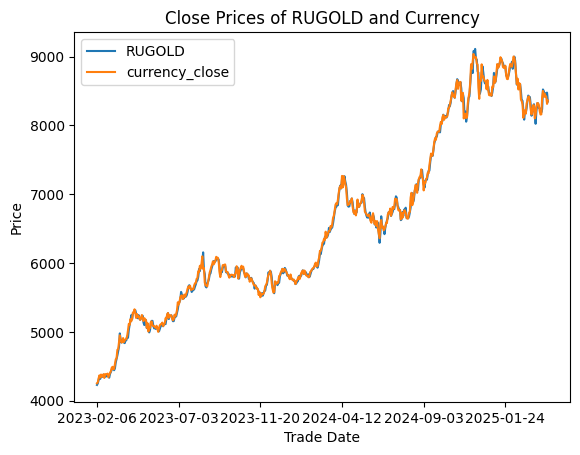

In [8]:
df = pd.DataFrame(fetch_data_from_db())
df.columns = ['tradedate', 'RUGOLD_c', 'RUGOLD', 'currency_secid', 'currency_close']
df.set_index('tradedate', inplace=True)
df = df[['RUGOLD', 'currency_close']]
df.plot(title='Close Prices of RUGOLD and Currency', ylabel='Price', xlabel='Trade Date')